In [1]:
# Preamble
from astropy.table import Table, column, vstack
import numpy as np
import os
import pandas as pd

%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt
# better-looking plots
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.figsize'] = (10.0, 8)
plt.rcParams['font.size'] = 18
mpl.ticker.AutoLocator.default_params['nbins'] = 5
mpl.ticker.AutoLocator.default_params['prune'] = 'both'

mpl.rcParams['ps.useafm'] = True
mpl.rcParams['pdf.use14corefonts'] = True
mpl.rcParams['text.usetex'] = True

import sys
sys.path.append('../astro_codes/')

In [2]:
gz2_data = Table.read('../fits/full_sample_debiased_w_low_z_mod.fits')

In [3]:
arc_data = Table.read('fits/arc_table_ml.fits')
ml_table_matched = Table.read('fits/ml_table_matched.fits')
gz2_stats = Table.read('fits/gz2_statistics.fits')

#### First task: define the sample:

In [4]:
def measure_N_detected(ids,arc_data):
    N_good = []
    pitch_angles = []
    for id_ in ids:
        arc_row_mask = arc_data['gxyName'] == id_
        N_total_id = arc_row_mask.sum()
        if N_total_id > 0:
            arcs_id = arc_data[arc_row_mask]
            good_arcs = arcs_id['p_good_predicted'] == 1
            N_good_id = good_arcs.sum()
            if N_good_id > 0:
                length_weights = arcs_id['arc_length'][good_arcs]
                Ps = arcs_id['pitch_angle_absolute'][good_arcs]
                pitch_angle = np.average(Ps,weights=length_weights)
            else:
                pitch_angle = -999
            
            N_good.append(N_good_id)
            pitch_angles.append(pitch_angle)
        else:
            N_good.append(-999)
            pitch_angles.append(-999)
    
    return np.array(N_good), np.array(pitch_angles)


in_ml = ml_table_matched['vmax_ok']
print('{} galaxies in ML sample'.format(in_ml.sum()))
ml_dr8ids = gz2_data['dr8objid'][in_ml]

Ns, psis = measure_N_detected(ml_dr8ids,arc_data)

galaxy_level_data = Table()
galaxy_level_data['dr8objid'] = ml_dr8ids
galaxy_level_data['dr7objid'] = gz2_data['dr7objid'][in_ml]
galaxy_level_data['N_arcs'] = Ns
galaxy_level_data['P_wtd_avg'] = psis

5688 galaxies in ML sample


/home/ppxrh/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:14: FutureWarning: np.average currently does not preserve subclasses, but will do so in the future to match the behavior of most other numpy functions such as np.mean. In particular, this means calls which returned a scalar may return a 0-d subclass object instead.


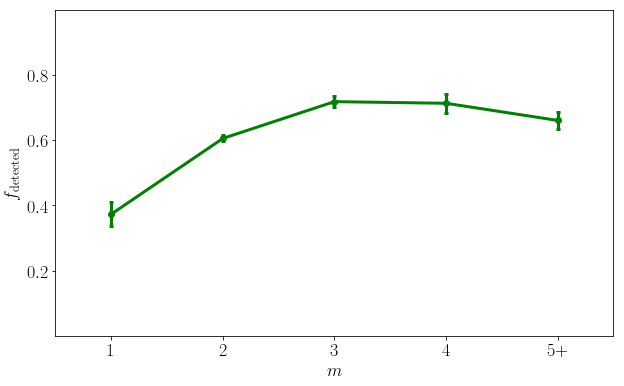

In [35]:
import imp
import bin_statistics
imp.reload(bin_statistics)

from bin_statistics import assign_bins, TableStats
mlabels = ('1','2','3','4','5+')

in_sparcfire = galaxy_level_data['N_arcs'] >= 0
#x = galaxy_level_data['N_arcs'][in_sparcfire]
bins = gz2_stats['m'][in_ml][in_sparcfire]
has_arcs = galaxy_level_data['N_arcs'][in_sparcfire] > 0

f = TableStats(has_arcs,bins).fraction_with_feature()

fig = plt.figure(figsize=(10,6))
ax = plt.subplot(111)

_ = ax.errorbar([1,2,3,4,5],f['f'],yerr=(f['f']-f['f-0.683']),color='g',
                marker='o',capsize=2,capthick=3,lw=3)

_ = ax.set_ylim(0,1)
_ = ax.set_xlim(0.5,5.5)
_ = ax.set_xticks([1,2,3,4,5])
_ = ax.set_xticklabels(mlabels)
_ = ax.set_xlabel('$m$')
_ = ax.set_ylabel('$f_\mathrm{detected}$')

In [6]:
from combining_catalogues import match_ids, make_matched_catalogue

ids_ = match_ids(gz2_data,galaxy_level_data,'dr7objid','dr7objid')
galaxy_level_matched = make_matched_catalogue(gz2_data,galaxy_level_data,
                                              ids_)
galaxy_level_matched['dr7objid'] = gz2_data['dr7objid']
galaxy_level_matched['dr8objid'] = gz2_data['dr8objid']

galaxy_level_data.write('fits/galaxy_level_data.fits',overwrite=True)
galaxy_level_matched.write('fits/galaxy_level_matched.fits',overwrite=True)

INFO:astropy:Upgrading Table to masked Table. Use Table.filled() to convert to unmasked table.


248883 galaxies in the reference catalogue
5688 galaxies in the match catalogue
---> 5688 matches in total
INFO: Upgrading Table to masked Table. Use Table.filled() to convert to unmasked table. [astropy.table.table]
